In [ ]:
!pip install datasets

In [1]:
!nvidia-smi

Fri Aug 29 05:28:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             44W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
#Storing model checkpoints in google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
from datasets import load_dataset

ds = load_dataset("roneneldan/TinyStories")

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00004-2d5a1467fff108(…):   0%|          | 0.00/249M [00:00<?, ?B/s]

data/train-00001-of-00004-5852b56a2bd28f(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/train-00002-of-00004-a26307300439e9(…):   0%|          | 0.00/246M [00:00<?, ?B/s]

data/train-00003-of-00004-d243063613e5a0(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/validation-00000-of-00001-869c898b5(…):   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

## 1. Tokenization

In [ ]:
!pip install tiktoken

In [35]:
import tiktoken
import os
import numpy as np
from tqdm.auto import tqdm

enc = tiktoken.get_encoding("gpt2")


In [ ]:
def process(example):
  ids = enc.encode_ordinary(example['text'])  #encode_ordinary ignores any special tokens
  out = {"ids":ids,"len":len(ids)}
  return out

if not os.path.exists("train.bin"):
  tokenized = ds.map(
      process,
      remove_columns=['text'],
      desc="tokenizing the splits",
      num_proc=8
  )

  for split, dset in tokenized.items():
    arr_len = np.sum(dset['len'],dtype=np.uint64)
    filename = f"{split}.bin"

    dtype = np.uint16
    arr = np.memmap(filename, dtype=dtype, mode='w+',shape=(arr_len,))
    total_batches = 1024

    idx = 0
    for batch_idx in tqdm(range(total_batches),desc=f"Writing {filename}"):
      batch = dset.shard(num_shards=total_batches, index=batch_idx, contiguous=True).with_format("numpy")
      # print(batch)
      arr_batch = np.concatenate(batch['ids'])
      arr[idx:idx+ len(arr_batch)] = arr_batch
      idx += len(arr_batch)
    arr.flush()



tokenizing the splits (num_proc=8):   0%|          | 0/2119719 [00:00<?, ? examples/s]

tokenizing the splits (num_proc=8):   0%|          | 0/21990 [00:00<?, ? examples/s]

Writing train.bin:   0%|          | 0/1024 [00:00<?, ?it/s]

Writing validation.bin:   0%|          | 0/1024 [00:00<?, ?it/s]

## 2. Creating input-output batches for the dataset

In [13]:
# Some functions from https://github.com/karpathy/nanoGPT/blob/master/train.py with slight modifications
#block size = context window
def get_batch(split):
    # We recreate np.memmap every batch to avoid a memory leak, as per
    # https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    if split == 'train':
        data = np.memmap(r'/content/drive/MyDrive/gemma_data/train.bin', dtype=np.uint16, mode='r')
    else:
        data = np.memmap(r'/content/drive/MyDrive/gemma_data/validation.bin', dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y


## 3. Defining the SLM Model Architecture

In [14]:
import torch
def compute_rope_params(head_dim, theta_base=10_000, context_length=4096, dtype=torch.float32):
    assert head_dim % 2 == 0, "Embedding dimension must be even"

    # Compute the inverse frequencies
    inv_freq = 1.0 / (theta_base ** (torch.arange(0, head_dim, 2, dtype=dtype)[: (head_dim // 2)].float() / head_dim))

    # Generate position indices
    positions = torch.arange(context_length, dtype=dtype)

    # Compute the angles
    angles = positions[:, None] * inv_freq[None, :]  # Shape: (context_length, head_dim // 2)

    # Expand angles to match the head_dim
    angles = torch.cat([angles, angles], dim=1)  # Shape: (context_length, head_dim)

    # Precompute sine and cosine
    cos = torch.cos(angles)
    sin = torch.sin(angles)

    return cos, sin


def apply_rope(x, cos, sin):
    # x: (batch_size, num_heads, seq_len, head_dim)
    batch_size, num_heads, seq_len, head_dim = x.shape
    assert head_dim % 2 == 0, "Head dimension must be even"

    # Split x into first half and second half
    x1 = x[..., : head_dim // 2]  # First half
    x2 = x[..., head_dim // 2 :]  # Second half

    # Adjust sin and cos shapes
    cos = cos[:seq_len, :].unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, seq_len, head_dim)
    sin = sin[:seq_len, :].unsqueeze(0).unsqueeze(0)

    # Apply the rotary transformation
    rotated = torch.cat((-x2, x1), dim=-1)
    x_rotated = (x * cos) + (rotated * sin)

    # It's ok to use lower-precision after applying cos and sin rotation
    return x_rotated.to(dtype=x.dtype)

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
import numpy as np
from tqdm.auto import tqdm
from contextlib import nullcontext
import os

class RMSNorm(nn.Module):
    def __init__(self, emb_dim, eps=1e-6, bias=False):
        super().__init__()
        self.eps = eps
        # Gemma3 stores zero-centered weights and uses (1 + weight) during forward
        self.scale = nn.Parameter(torch.zeros(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim)) if bias else None

    def forward(self, x):
        # Match HF Gemma3: compute norm in float32, then scale by (1 + w)
        input_dtype = x.dtype
        x_f = x.float()
        var = x_f.pow(2).mean(dim=-1, keepdim=True)
        x_norm = x_f * torch.rsqrt(var + self.eps)
        out = x_norm * (1.0 + self.scale.float())

        if self.shift is not None:
            out = out + self.shift.float()

        return out.to(input_dtype)



class GroupedQueryAttention(nn.Module):
    def __init__(
        self, d_in, num_heads, num_kv_groups, head_dim=None, qk_norm=False,
        query_pre_attn_scalar=None, dtype=None,
    ):
        super().__init__()
        assert num_heads % num_kv_groups == 0, "num_heads must be divisible by num_kv_groups"

        self.num_heads = num_heads
        self.num_kv_groups = num_kv_groups
        self.group_size = num_heads // num_kv_groups

        if head_dim is None:
            assert d_in % num_heads == 0, "`d_in` must be divisible by `num_heads` if `head_dim` is not set"
            head_dim = d_in // num_heads

        self.head_dim = head_dim
        self.d_out = num_heads * head_dim

        self.W_query = nn.Linear(d_in, self.d_out, bias=False, dtype=dtype)
        self.W_key = nn.Linear(d_in, num_kv_groups * head_dim, bias=False, dtype=dtype)
        self.W_value = nn.Linear(d_in, num_kv_groups * head_dim, bias=False, dtype=dtype)

        self.out_proj = nn.Linear(self.d_out, d_in, bias=False, dtype=dtype)

        if qk_norm:
            self.q_norm = RMSNorm(head_dim, eps=1e-6)
            self.k_norm = RMSNorm(head_dim, eps=1e-6)
        else:
            self.q_norm = self.k_norm = None

        if query_pre_attn_scalar is not None:
            self.scaling = (query_pre_attn_scalar) ** -0.5
        else:
            self.scaling = (head_dim) ** -0.5


    def forward(self, x, mask, cos, sin):
        b, num_tokens, _ = x.shape

        # Apply projections
        queries = self.W_query(x)  # (b, num_tokens, num_heads * head_dim)
        keys = self.W_key(x)       # (b, num_tokens, num_kv_groups * head_dim)
        values = self.W_value(x)   # (b, num_tokens, num_kv_groups * head_dim)

        # Reshape
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        keys = keys.view(b, num_tokens, self.num_kv_groups, self.head_dim).transpose(1, 2)
        values = values.view(b, num_tokens, self.num_kv_groups, self.head_dim).transpose(1, 2)

        # Optional normalization
        if self.q_norm:
            queries = self.q_norm(queries)
        if self.k_norm:
            keys = self.k_norm(keys)

        # Apply RoPE
        queries = apply_rope(queries, cos, sin)
        keys = apply_rope(keys, cos, sin)

        # Expand K and V to match number of heads
        keys = keys.repeat_interleave(self.group_size, dim=1)
        values = values.repeat_interleave(self.group_size, dim=1)

        # Scale queries
        queries = queries * self.scaling

        # Attention
        attn_scores = queries @ keys.transpose(2, 3)
        attn_scores = attn_scores.masked_fill(mask, -torch.inf)
        attn_weights = torch.softmax(attn_scores, dim=-1)

        context = (attn_weights @ values).transpose(1, 2).reshape(b, num_tokens, self.d_out)
        return self.out_proj(context)

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.fc1 = nn.Linear(cfg["emb_dim"], cfg["hidden_dim"], dtype=cfg["dtype"], bias=False)
        self.fc2 = nn.Linear(cfg["emb_dim"], cfg["hidden_dim"], dtype=cfg["dtype"], bias=False)
        self.fc3 = nn.Linear(cfg["hidden_dim"], cfg["emb_dim"], dtype=cfg["dtype"], bias=False)

    def forward(self, x):
        x_fc1 = self.fc1(x)
        x_fc2 = self.fc2(x)
        x = nn.functional.gelu(x_fc1, approximate="tanh") * x_fc2
        return self.fc3(x)


class TransformerBlock(nn.Module):

    def __init__(self, cfg: dict, attn_type: str):
        super().__init__()
        self.attn_type = attn_type

        self.att = GroupedQueryAttention(
            d_in=cfg["emb_dim"],
            num_heads=cfg["n_heads"],
            num_kv_groups=cfg["n_kv_groups"],
            head_dim=cfg["head_dim"],
            qk_norm=cfg["qk_norm"],
            query_pre_attn_scalar=cfg["query_pre_attn_scalar"],
            dtype=cfg["dtype"],
        )
        self.ff = FeedForward(cfg)
        self.input_layernorm = RMSNorm(cfg["emb_dim"], eps=1e-6)
        self.post_attention_layernorm = RMSNorm(cfg["emb_dim"], eps=1e-6)
        self.pre_feedforward_layernorm = RMSNorm(cfg["emb_dim"], eps=1e-6)
        self.post_feedforward_layernorm = RMSNorm(cfg["emb_dim"], eps=1e-6)

    def forward(
        self,
        x,
        mask_global,
        mask_local,
        cos_global,
        sin_global,
        cos_local,
        sin_local,
    ):
        # Shortcut connection for attention block
        shortcut = x
        x = self.input_layernorm(x)

        if self.attn_type == "sliding_attention":
            attn_mask = mask_local
            cos = cos_local
            sin = sin_local
        else:
            attn_mask = mask_global
            cos = cos_global
            sin = sin_global

        x_attn = self.att(x, attn_mask, cos, sin)
        x_attn = self.post_attention_layernorm(x_attn)
        x = shortcut + x_attn

        # Shortcut connection for feed forward block
        shortcut = x
        x_ffn = self.pre_feedforward_layernorm(x)
        x_ffn = self.ff(x_ffn)
        x_ffn = self.post_feedforward_layernorm(x_ffn)
        x = shortcut + x_ffn
        return x

class Gemma3Model(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        assert cfg["layer_types"] is not None and len(cfg["layer_types"]) == cfg["n_layers"]

        # Main model parameters
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"], dtype=cfg["dtype"])

        self.blocks = nn.ModuleList([
            TransformerBlock(cfg, attn_type)for attn_type in cfg["layer_types"]
        ])

        self.final_norm = RMSNorm(cfg["emb_dim"], eps=1e-6)
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False, dtype=cfg["dtype"])
        self.cfg = cfg

        # Reusuable utilities
        cos_local, sin_local = compute_rope_params(
            head_dim=cfg["head_dim"],
            theta_base=cfg["rope_local_base"],
            context_length=cfg["context_length"],
            dtype=torch.float32,
        )
        cos_global, sin_global = compute_rope_params(
            head_dim=cfg["head_dim"],
            theta_base=cfg["rope_base"],
            context_length=cfg["context_length"],
            dtype=torch.float32,
        )
        self.register_buffer("cos_local", cos_local, persistent=False)
        self.register_buffer("sin_local", sin_local, persistent=False)
        self.register_buffer("cos_global", cos_global, persistent=False)
        self.register_buffer("sin_global", sin_global, persistent=False)

    def _create_masks(self, seq_len, device):
        ones = torch.ones((seq_len, seq_len), dtype=torch.bool, device=device)

        # mask_global (future is masked: j > i)
        #     j:  0 1 2 3 4 5 6 7
        #  i
        #     0:  0 1 1 1 1 1 1 1
        #     1:  0 0 1 1 1 1 1 1
        #     2:  0 0 0 1 1 1 1 1
        #     3:  0 0 0 0 1 1 1 1
        #     4:  0 0 0 0 0 1 1 1
        #     5:  0 0 0 0 0 0 1 1
        #     6:  0 0 0 0 0 0 0 1
        #     7:  0 0 0 0 0 0 0 0
        mask_global = torch.triu(ones, diagonal=1)

        # far_past (too far back is masked: i - j >= sliding_window)
        # where sliding_window = 4
        #     j:  0 1 2 3 4 5 6 7
        #  i
        #     0:  0 0 0 0 0 0 0 0
        #     1:  0 0 0 0 0 0 0 0
        #     2:  0 0 0 0 0 0 0 0
        #     3:  0 0 0 0 0 0 0 0
        #     4:  1 0 0 0 0 0 0 0
        #     5:  1 1 0 0 0 0 0 0
        #     6:  1 1 1 0 0 0 0 0
        #     7:  1 1 1 1 0 0 0 0
        far_past = torch.triu(ones, diagonal=self.cfg["sliding_window"]).T

        # Local (sliding_window) = future OR far-past
        # mask_local
        #     j:  0 1 2 3 4 5 6 7
        # i
        # 0:      0 1 1 1 1 1 1 1
        # 1:      0 0 1 1 1 1 1 1
        # 2:      0 0 0 1 1 1 1 1
        # 3:      0 0 0 0 1 1 1 1
        # 4:      1 0 0 0 0 1 1 1
        # 5:      1 1 0 0 0 0 1 1
        # 6:      1 1 1 0 0 0 0 1
        # 7:      1 1 1 1 0 0 0 0
        mask_local = mask_global | far_past
        return mask_global, mask_local

    def forward(self, input_ids, targets=None):
        b, seq_len = input_ids.shape
        x = self.tok_emb(input_ids) * (self.cfg["emb_dim"] ** 0.5)
        mask_global, mask_local = self._create_masks(seq_len, x.device)

        for block in self.blocks:
            x = block(
                x,
                mask_global=mask_global,
                mask_local=mask_local,
                cos_global=self.cos_global,
                sin_global=self.sin_global,
                cos_local=self.cos_local,
                sin_local=self.sin_local,
            )

        x = self.final_norm(x)
        logits = self.out_head(x.to(self.cfg["dtype"]))
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), targets.reshape(-1))
        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
      for _ in range(max_new_tokens):
        ctx_len = self.cfg["context_length"]
        idx_cond = idx if idx.size(1) <= ctx_len else idx[:, -ctx_len:]
        logits, _ = self(idx_cond)  # targets=None by default
        logits = logits[:, -1, :] / temperature
        if top_k is not None:
            v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
            logits[logits < v[:, [-1]]] = float("-inf")
        probs = F.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, idx_next), dim=1)
      return idx



In [16]:
GEMMA3_CONFIG_270M = {
    "vocab_size": 50257,
    "context_length": 32_768,
    "emb_dim": 640,
    "n_heads": 4,
    "n_layers": 18,
    "hidden_dim": 2048,
    "head_dim": 256,
    "qk_norm": True,
    "n_kv_groups": 1,
    "rope_local_base": 10_000.0,
    "rope_base": 1_000_000.0,
    "sliding_window": 512,
      "layer_types": [
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "full_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "full_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "full_attention"
    ],
    "dtype": torch.bfloat16,
    "query_pre_attn_scalar": 256,
}

torch.manual_seed(123)
model = Gemma3Model(GEMMA3_CONFIG_270M)

## 4. Defining the Loss function

In [17]:
# Defining the loss function
def estimate_loss(model):
  out = {}
  model.eval()
  with torch.inference_mode():
    for split in ['train', 'val']:
      losses = torch.zeros(eval_iters)
      for k in range(eval_iters):
        X, Y = get_batch(split)
        with ctx:
          logits, loss = model(X,Y)

        losses[k] = loss.item()
      out[split] = losses.mean()
  model.train()
  return out

## 5. Defining SLM Training configuration Part 1


In [29]:

learning_rate = 1e-4 #more stable training, earlier 1e-4
max_iters = 150000 #increase from 25000
warmup_steps = 1000 #smoother initial train, earlier 100
min_lr = 5e-4 #lower rate, earlier 5e-4
eval_iters = 2000 # increased from 100
batch_size = 32 # changed from 16, better gradient estimate
block_size = 128 #changed from 64, capture longer range dependencies

gradient_accumulation_steps = 32

device =  "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast

# note: float16 data type will automatically use a GradScaler

# How to use autocast https://wandb.ai/wandb_fc/tips/reports/How-To-Use-Autocast-in-PyTorch--VmlldzoyMTk4NTky
#dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(42)

## 6. Defining SLM Training configuration Part 2


In [30]:
from torch.optim.lr_scheduler import LinearLR,SequentialLR, CosineAnnealingLR

## Put in weight decay, changed BETA2 to 0.95
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate, betas = (0.9, 0.95), weight_decay=0.1, eps=1e-9)

scheduler_warmup = LinearLR(optimizer, total_iters=warmup_steps)
scheduler_decay = CosineAnnealingLR(optimizer, T_max = max_iters- warmup_steps, eta_min = min_lr)
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_decay], milestones=[warmup_steps])

scaler = torch.cuda.amp.GradScaler(enabled=(dtype=="float16"))

/tmp/ipython-input-1803005204.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype=="float16"))


## 7. Pre-train the SLM

In [31]:
import os
import threading
from tqdm.auto import tqdm

# === Setup ===
resume = True  # set to False if training from scratch
checkpoint_dir = "/content/drive/MyDrive/gemma_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_file = os.path.join(checkpoint_dir, "checkpoint.pt")

start_epoch = 0
best_val_loss = float('inf')
train_loss_list, validation_loss_list = [], []

# === Resume from checkpoint if available ===
if resume and os.path.exists(checkpoint_file):
    print("🔁 Resuming from checkpoint...")
    checkpoint = torch.load(checkpoint_file)
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])
    meta = checkpoint.get("meta", {})
    start_epoch = meta.get("epoch", 0)
    best_val_loss = meta.get("best_val_loss", float("inf"))
    train_loss_list = meta.get("train_loss_list", [])
    validation_loss_list = meta.get("validation_loss_list", [])

model = model.to(device)

# === Training loop ===
for epoch in tqdm(range(start_epoch, max_iters)):
    if epoch % eval_iters == 0 and epoch != 0:
        losses = estimate_loss(model)
        print(f"Epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        print(f"Current learning rate: {optimizer.param_groups[0]['lr']:.5f}")
        train_loss_list.append(losses['train'])
        validation_loss_list.append(losses['val'])

        if losses['val'] < best_val_loss:
          best_val_loss = losses['val']
          threading.Thread(
              target=lambda m=model.state_dict(): torch.save(m, os.path.join(checkpoint_dir, "best_model_params.pt"),
                                                              _use_new_zipfile_serialization=False),
              daemon=True
          ).start()


    X, y = get_batch("train")
    X, y = X.to(torch.long).to(device), y.to(torch.long).to(device)

    with ctx:
        logits, loss = model(X, y)
        loss = loss / gradient_accumulation_steps
        scaler.scale(loss).backward()

    if ((epoch + 1) % gradient_accumulation_steps == 0) or (epoch + 1 == max_iters):
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

    scheduler.step()

    # Save checkpoint every 2000 epochs or at the last epoch asynchronously
    if epoch % 2000 == 0 or epoch + 1 == max_iters:
      # Prepare checkpoint data first
      checkpoint_data = {
          "model": model.state_dict(),
          "optimizer": optimizer.state_dict(),
          "scaler": scaler.state_dict(),
          "meta": {
              "epoch": epoch + 1,
              "best_val_loss": best_val_loss,
              "train_loss_list": train_loss_list,
              "validation_loss_list": validation_loss_list
          }
      }

      # Save asynchronously in background thread
      threading.Thread(
          target=lambda d=checkpoint_data: torch.save(d, checkpoint_file, _use_new_zipfile_serialization=False),
          daemon=True
      ).start()


🔁 Resuming from checkpoint...


  0%|          | 0/45999 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRE

Epoch 106000: train loss 1.8369, val loss 1.8484
Current learning rate: 0.00010
Epoch 108000: train loss 1.8103, val loss 1.8313
Current learning rate: 0.00010
Epoch 110000: train loss 1.8033, val loss 1.8218
Current learning rate: 0.00010
Epoch 112000: train loss 1.7956, val loss 1.8142
Current learning rate: 0.00010
Epoch 114000: train loss 1.7814, val loss 1.8068
Current learning rate: 0.00010
Epoch 116000: train loss 1.7897, val loss 1.8043
Current learning rate: 0.00011
Epoch 118000: train loss 1.7836, val loss 1.8024
Current learning rate: 0.00011
Epoch 120000: train loss 1.7816, val loss 1.7924
Current learning rate: 0.00011
Epoch 122000: train loss 1.7757, val loss 1.7891
Current learning rate: 0.00011
Epoch 124000: train loss 1.7757, val loss 1.7843
Current learning rate: 0.00012
Epoch 126000: train loss 1.7698, val loss 1.7851
Current learning rate: 0.00012
Epoch 128000: train loss 1.7654, val loss 1.7815
Current learning rate: 0.00012
Epoch 130000: train loss 1.7601, val los

## 8. Plotting the SLM Loss function

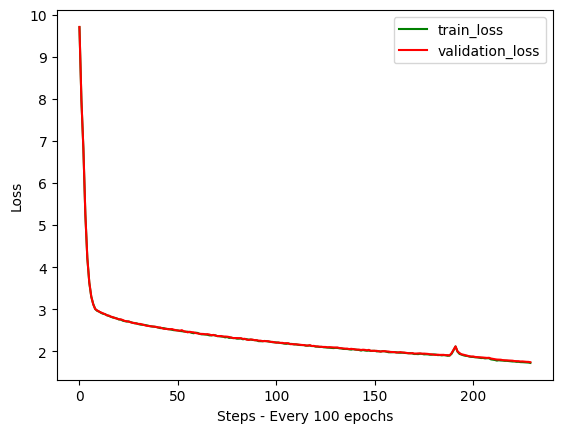

In [32]:
import matplotlib.pyplot as plt
train_loss_list_converted = [i.cpu().detach() for i in train_loss_list]
validation_loss_list_converted = [i.cpu().detach() for i in validation_loss_list]

plt.plot(train_loss_list_converted, 'g', label='train_loss')
plt.plot(validation_loss_list_converted, 'r', label='validation_loss')
plt.xlabel("Steps - Every 100 epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


## Running SLM Inference on our trained model

In [33]:
#Inferencing the Model

model = Gemma3Model(GEMMA3_CONFIG_270M)  # re-create the model with same config
checkpoint = torch.load(checkpoint_file)
model.load_state_dict(checkpoint["model"])


<All keys matched successfully>

In [37]:
sentence = "There was a little"
context = torch.tensor(enc.encode(sentence), dtype=torch.long).unsqueeze(0).to(device)
# context
context.shape

torch.Size([1, 4])

In [47]:
response = model.generate(context, max_new_tokens=200, temperature=1.5, top_k=5)
print(enc.decode(response.squeeze().tolist()))

There was a little girl, her name was Daisy, and she was three years old, who lived with her family. One day, Daisy went on an exciting journey. She had heard that if she kept going and kept getting bigger, she would be successful.

When Daisy reached the end of her adventure, she found a giant rock with a big hole in it, but it wouldn't budge. She asked her family what it was and they said it was an old rock and it had come from the sky, but it was very far away. They had come to find her there.

When they got there, they noticed the rock was in a lotion and she was scared. But Daisy knew she had to be brave, so she decided to go and get the rock. She carefully placed it back on the ground and started to rock it.

As the little rock began to rock, it was very heavy. Daisy tried her new best but it was no use! Daisy was getting very


In [48]:
sentence = "A cat sat on the red mat"
context = torch.tensor(enc.encode(sentence), dtype=torch.long).unsqueeze(0).to(device)
response = model.generate(context, max_new_tokens=200, temperature=1.5, top_k=5)
print(enc.decode(response.squeeze().tolist()))

A cat sat on the red mat. They both wanted to play with the red ball too. They did not know it was her turn. They were very competitive.

Then, the cat jumped on them. The red ball rolled away and hit their ball in the head. The red ball rolled under the bed. It bounced away. The cat ran to the door and jumped on. The red ball rolled into the room.

Lily and the red ball rolled under the bed. It went into the room and found a hole. They crawled through the hole and found a big room. There was a bed and a closet and a chair. They were very happy. They played with the ball and the chair and each other. They were best friends and had fun together.Lily and Max are friends. They like to play together. Lily has a big book. It is a picture of a dragon. Lily likes the book. She says it makes funny sounds when she moves the ball.

"Zee!"


In [50]:
sentence = "A boy took admission in data science and"
context = torch.tensor(enc.encode(sentence), dtype=torch.long).unsqueeze(0).to(device)
response = model.generate(context, max_new_tokens=200, temperature=1.1, top_k=5)
print(enc.decode(response.squeeze().tolist()))

A boy took admission in data science and asked the man if he could borrow a toy. The man said yes and showed him where to find a toy. The little boy was very happy and thanked the man.

The man went on his way. As he walked, he met a new friend. They played together in the park and had a lot of fun. The man was happy to have a new friend.Once upon a time, there was a little girl named Lily. She was very excited because she was going to a party. Her mommy gave her a big bag of cookies to share with her friends.

When they got to the party, they saw a man with a funny hat and a long, fluffy tail. He said hello to the children and asked them to play. Lily felt happy and joined in the fun.

As they were playing, Lily noticed that the man was wearing a funny hat. She felt sad and asked her mommy why the man was wearing a funny hat. Her mommy


In [51]:
sentence = "a boy found injured wolf in the dark forest"
context = torch.tensor(enc.encode(sentence), dtype=torch.long).unsqueeze(0).to(device)
response = model.generate(context, max_new_tokens=200, temperature=1.1, top_k=5)
print(enc.decode(response.squeeze().tolist()))

a boy found injured wolf in the dark forest. The boy was scared and ran away as fast as he could. The wolf was happy to be safe, but he was also sad because he lost his way home.Once upon a time, there was a little girl named Lily. She loved to play outside in her garden. One day, she saw a caterpillar crawling on the ground. It looked sad because it was lost and couldn't find its way out.

Lily picked up the caterpillar and took it back to her garden. She saw that the caterpillar's home was still there, waiting for Lily to come home. Lily felt sad for the caterpillar and decided to give it some water. She brought the caterpillar back to Lily and she was so happy.

But the next day, Lily's mommy told her that the caterpillar was lost. She said that it was lost forever. Lily was very sad that she had to give the caterpillar to her home. She learned that sometimes it's better


In [53]:
sentence = "The woodcutter's axe fell in river"
context = torch.tensor(enc.encode(sentence), dtype=torch.long).unsqueeze(0).to(device)
response = model.generate(context, 200)
print(enc.decode(response.squeeze().tolist()))

The woodcutter's axe fell in river. It landed in a beautiful field. It was big and small but it was kicked away by a dog. The man watched as the woodpecker went up to the dog and roared. He then took a closer look at it and it was a small, rocking with shining water on the wood again. The man was amazed and bowed his head again.

From that day on, the man continued to lean hard every day, always remembering the kind lava he saw. He would take it out in the sunshine and take care of it. It kept him safe and warm and now want to be away from the hot dog.Once upon a time, there was a little boy named Timmy. He loved to explore and discover new things. One day, he was playing in his backyard when he saw a pole in the distance. He wanted to watch it all by himself. 

But the pole was very old and rusty. Timmy didn't understand why it was causing for something.


In [55]:
torch.save(model.state_dict(), "final_model_params.pt")